# Практическое занятие №8

## Литература

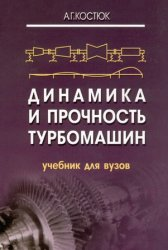

<p style="text-align: center;">Теория: Костюк А.Г. Динамика и прочность турбомашин</p>

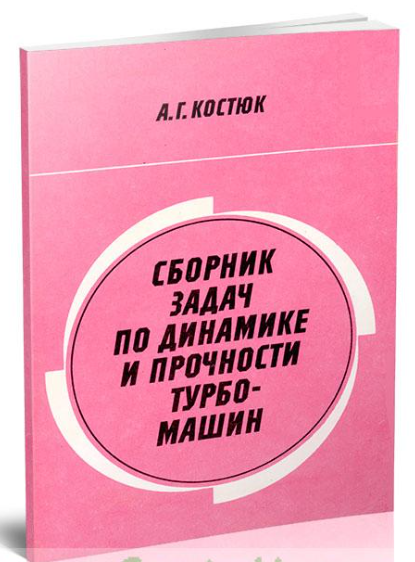

<p style="text-align: center;">Задачи: Костюк А.Г. Сборник задач по динамике и прочности турбомашин</p>


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from typing import Callable, List, Tuple, Union, Optional

from scipy.integrate import dblquad, quad

In [3]:
MPa = 1e6
kW = 1e3
MW = 1e6
mm = 1e-3

# Оценки напряжений в рабочих лопатках турбинной ступени
## Напряжение от растяжения лопаток

$$F=ma$$
$$a = \omega^2 \cdot R_{ср}$$
$$R = 0.5 d_{ср}$$
$$m = \rho_{металла} \cdot V_{металла}$$
$$F = 0.5 \cdot \rho_{металла} \cdot V_{металла} \cdot d_{ср} \cdot \omega^2$$


Для лопатки с постоянным сечением усилия в корне лопаки
$$F = 0.5 \cdot \rho_{металла} \cdot F_{сечения} \cdot l \cdot d_{ср} \cdot \omega^2$$
$$ \sigma = F / F_{сечения} $$
$$ \sigma = 0.5 \cdot \rho_{металла} \cdot l \cdot d_{ср} \cdot \omega^2$$

Для лопатки с постоянным сечением распределение напряжения по высоте лопатки можно выразить следующим образом:

$$\sigma(x) = \rho \cdot \omega^2 \cdot [r_{кор}(l - x) + 0.5(l^2 - x ^ 2)]$$

## Напряжение изгиба

В Упрощенной форме можно записать как:

$$\sigma_{изг} = \frac{G\cdot H_0\cdot\eta_{oi}\cdot l_2}{2\cdot u \cdot e \cdot z_2 \cdot W_{min}}$$

### Задача 1

Для рабочей лопатки постоянного профиля длинной 0.2 м и средний диаметр 1.55 м выполненой из стали 20Х13 (плотность 7800 кг/м3), найти максимальное значние напряжений растяжения и изгиба, а так же получить распределение напряжений по длине лопатки. Степень парциальности ступени при трех открытых РК е=0.85, количество лопаток z=126 штук. Момент их сопротивления W = 0.19 см3. Для представленных условий лопаточная мощность ступени N = 1200 кВт. Оценить как изменятся напряжения растяжения при отключении электрогенератора от сети и повышении частоты вращения ротора на 10%. Определить напряжения изгиба для режима эксплуатации с одним открытым РК (е=0.3) при котором N=900 кВт

In [4]:
l = 0.2
avg_d = 1.55
density = 7800
z = 126
n = 50
W = 0.19 * 1e-6

Из материала известно что предел текучести $\sigma_{0.2}$ = 400 МПа. Принимая коэффициент запаса прочности 1.7, допускаемые напряжения $\sigma_{р} = 235 МПа$

In [5]:
max_stress = 400 * MPa
max_allowed_stress = 235 * MPa

Напряжения в корневом сечении лопатки

In [6]:
tension_stress_root_func = lambda x: 0.5 * density * (x ** 2) * avg_d * l

In [11]:
angular_speed = 2 * np.pi * n
assert tension_stress_root_func(angular_speed) < max_allowed_stress

tension_stress_root_func(angular_speed) / MPa

119.32351720917035

In [8]:
print(f"Запас прочности: {max_stress / tension_stress_root_func(angular_speed)}")

Запас прочности: 3.3522310551641943


Напряжения в корне при увеличении частоты вращения на 10%

In [12]:
increased_angular_speed = 1.1 * angular_speed
assert tension_stress_root_func(increased_angular_speed) < max_allowed_stress
tension_stress_root_func(increased_angular_speed) / MPa

144.38145582309613

In [13]:
print(f"Запас прочности: {max_stress / tension_stress_root_func(increased_angular_speed)}")

Запас прочности: 2.7704388885654496


Распределение напряжений от растяжения по высоте

In [14]:
def tension_stress(x):
    r_root = (avg_d - l) / 2
    constant_part = density * (angular_speed ** 2)
    left = r_root * (l - x)
    right = 0.5 * ((l ** 2) - (x ** 2))
    return constant_part * (left + right)

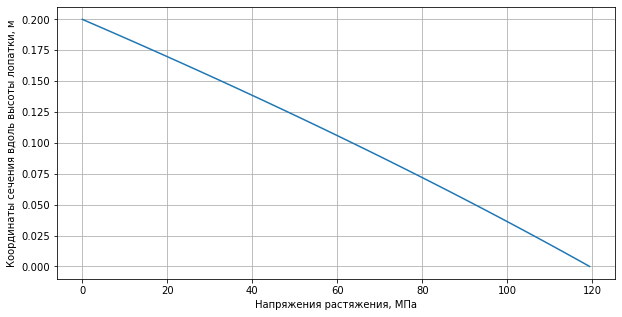

In [16]:
y = np.linspace(0, l, 100)

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(tension_stress(y) / MPa, y)
ax.set_xlabel("Напряжения растяжения, МПа")
ax.set_ylabel("Координаты сечения вдоль высоты лопатки, м")
ax.grid()

Окружная скорость

In [17]:
u = np.pi * avg_d * n
u

243.47343065320896

Напряжение изгиба при открытых клапанах

In [18]:
def bending_stress(N, e):
    numenator = N * l
    denumenator = 2 * u * e * z * W
    return numenator / denumenator

In [19]:
N = 1200 * kW
e = 0.85
bending_stress(N, e) / MPa

24.220694901107855

Напряжения изгиба при одном открытом клапане

In [20]:
N = 900 * kW
e = 0.3
bending_stress(N, e) / MPa

51.46897666485419

Обычно принимаю для ступеней активного типа с е<1 значения допускаемых напряжений на изгиб порядка 15-20 МПа. Так как выбранная хорда профиля рабочей лопатки не обеспечивает необходимого значения допускаемого напряжения, то значение хорды для выполнения условий прочности определяется по формуле $b^{new} = b \cdot \sqrt{\sigma_{изгиб} / \sigma_{доп}} $

# Пример пространственного расчета

### Пример профиля

In [21]:
def naca_profile_coordinates(
    number: str,
    chord: float,
    points: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    m = int(number[0]) / 100.
    p = int(number[1]) / 10.
    t = int(number[2:]) / 100.
    
    x = np.linspace(0, chord, points)
    
    yc = np.where(
        x < p * chord,
        m * x / p ** 2 * (2 * p - x / chord),
        m * (chord - x) / (1 - p) ** 2 * (1 + x / chord - 2 * p)
    )
    
    theta = np.arctan(
        np.where(
            x < p * chord,
            2 * m / p ** 2 * (p - x / chord),
            2 * m / (1 - p) ** 2 * (p - x / chord)
        )
    )
    
    r = x / chord
    yt = 5 * t * chord * (
        0.2969 * r ** 0.5 - 0.1260 * r - 0.3516 * r ** 2 + 0.2843 * r ** 3 - 0.1015 * r ** 4
    )
    
    xu = x - yt * np.sin(theta)
    yu = yc + yt * np.cos(theta)
    
    xl = x + yt * np.sin(theta)
    yl = yc - yt * np.cos(theta)
    
    
    return xu, yu, xl, yl

In [22]:
from ipywidgets import interact, IntSlider


def plot_naca_profile(m: int, p: int, t: int):
    number = str(int(m)) + str(int(p)) + str(int(t))
    xu, yu, xl, yl = naca_profile_coordinates(number, chord=0.05, points=100)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    ax.plot(xu, yu)
    ax.plot(xl, yl)
    ax.set_aspect("equal", adjustable="box")
    x_text = min(min(xu), min(xl)) * 0.95
    y_text = max(max(yu), max(yl)) * 1.05
    ax.set_title(f"Profile type NACA {number} with")

interact(
    plot_naca_profile,
    m=IntSlider(min=1, max=9, step=1, value=2),
    p=IntSlider(min=1, max=9, step=1, value=4),
    t=IntSlider(min=1, max=99, step=1, value=21),
);

interactive(children=(IntSlider(value=2, description='m', max=9, min=1), IntSlider(value=4, description='p', m…

### Соберем NACA лопатку по сечениям через центр тяжести

In [23]:
def get_area_of_profile(
    upper_line_points: np.ndarray,
    lower_line_points: np.ndarray,
    return_lines: bool = False
) -> float:
    """
    Compute profile area in integral form
    :param np.ndarray upper_line_points: np.ndarray[X, Y] coordinates of upper profile line
    :param np.ndarray lower_line_points: np.ndarray[X, Y] coordinates of lower profile line
    :return Tuple[float, Callable, Callable]]:
    """
    upper_line_coefficients = np.polyfit(upper_line_points[:, 0], upper_line_points[:, 1], 17)
    upper_line = np.poly1d(upper_line_coefficients)

    lower_line_coefficients = np.polyfit(lower_line_points[:, 0], lower_line_points[:, 1], 17)
    lower_line = np.poly1d(lower_line_coefficients)

    x_min = min(min(upper_line_points[:, 0]), min(lower_line_points[:, 0]))
    x_max = max(max(upper_line_points[:, 0]), max(lower_line_points[:, 0]))

    profile_area = dblquad(
        lambda y, x: 1,
        a=x_min,
        b=x_max,
        gfun=lower_line,
        hfun=upper_line,
        epsrel=1e-16,
    )[0]
    if return_lines:
        return profile_area, upper_line, lower_line
    return profile_area


def get_center_of_mass_coordinates(upper_line_points: np.ndarray, lower_line_points: np.ndarray) -> Tuple[float, float]:
    """
    Compute coordinates of profile center of mass in integral form
    :param np.ndarray upper_line_points: np.ndarray[X, Y] coordinates of upper profile line
    :param np.ndarray lower_line_points: np.ndarray[X, Y] coordinates of lower profile line
    :return Tuple[float, float]: X, Y
    """

    profile_area, upper_line, lower_line = get_area_of_profile(
        upper_line_points=upper_line_points,
        lower_line_points=lower_line_points,
        return_lines=True
    )

    x_min = min(min(upper_line_points[:, 0]), min(lower_line_points[:, 0]))
    x_max = max(max(upper_line_points[:, 0]), max(lower_line_points[:, 0]))

    integral_x = dblquad(
        lambda y, x: x,
        a=x_min,
        b=x_max,
        gfun=lower_line,
        hfun=upper_line,
        epsrel=1e-16,
    )[0]
    integral_y = dblquad(
        lambda y, x: y,
        a=x_min,
        b=x_max,
        gfun=lower_line,
        hfun=upper_line,
        epsrel=1e-16,
    )[0]

    x_center = integral_x / profile_area
    y_center = integral_y / profile_area

    return x_center, y_center

In [24]:
def build_3d_scatters(l: float, m: int, p: int, t: int):

    step = -int((t - 11) / 20)
    numbers = [f"{int(m)}{int(p)}{int(last)}" for last in range(t, 11, -1)]
    blade_length = l
    z_values = np.linspace(0, blade_length, len(numbers))

    x_to_stack = []
    y_to_stack = []
    z_to_stack = []

    areas = []


    for number, z_val in zip(numbers, z_values):
        xu, yu, xl, yl = naca_profile_coordinates(number, chord=0.05, points=100)
        z = np.ones_like(xu) * z_val
        upper_line_points = np.vstack((xu, yu, z)).T
        lower_line_points = np.vstack((xl, yl, z)).T

        x_center, y_center = get_center_of_mass_coordinates(
        upper_line_points=upper_line_points,
        lower_line_points=lower_line_points,
        )
        upper_line_points[:, 0] -= x_center
        lower_line_points[:, 0] -= x_center

        upper_line_points[:, 1] -= y_center
        lower_line_points[:, 1] -= y_center

        areas.append(
            get_area_of_profile(
                upper_line_points=upper_line_points,
                lower_line_points=lower_line_points
            )
        )


        full_points = np.vstack((upper_line_points, lower_line_points[::-1]))
        x_coordinates = full_points[:, 0]
        y_coordinates = full_points[:, 1]
        z_coordinates = full_points[:, 2]

        x_to_stack.append(x_coordinates)
        y_to_stack.append(y_coordinates)
        z_to_stack.append(z_coordinates)

    x_stacked = np.vstack(x_to_stack).T
    y_stacked = np.vstack(y_to_stack).T
    z_stacked = np.vstack(z_to_stack).T
    return x_stacked, y_stacked, z_stacked, (z_values, areas)

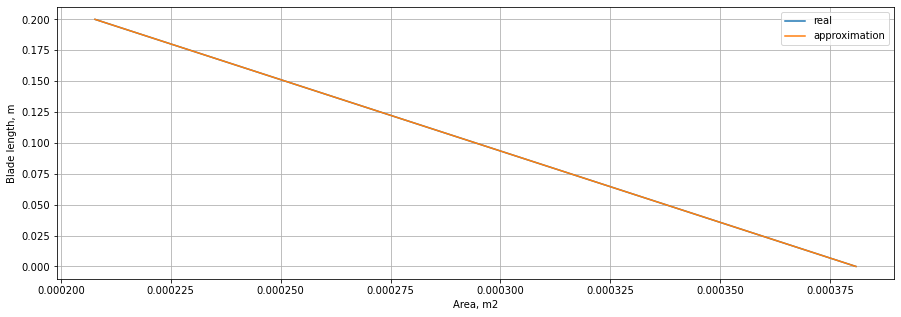

In [27]:
x_stacked, y_stacked, z_stacked, (z_values, areas) = build_3d_scatters(l, 8, 6, 22)

f_area = np.poly1d(np.polyfit(z_values, areas, 3))

fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(areas, z_values, label='real')
ax.plot(f_area(z_values), z_values, label='approximation')
ax.legend()
ax.set_xlabel("Area, m2")
ax.set_ylabel("Blade length, m")
ax.grid();

### Отрисуем собранную лопатку

In [28]:
def set_axes_equal(ax: Optional[plt.axes]) -> None:
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.
    :param matplotlib.pyplot.axes ax:a matplotlib axis, e.g., as output from plt.gca().
    :return None:
    """
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5 * max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

<IPython.core.display.Javascript object>


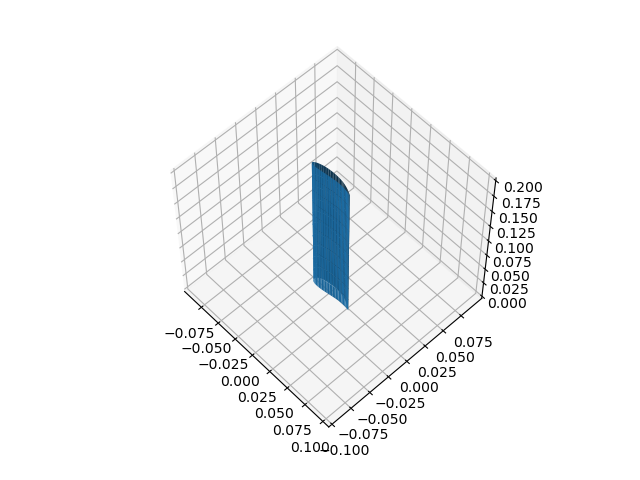

In [29]:
%matplotlib notebook

_, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot_surface(x_stacked, y_stacked, z_stacked)
ax.set_box_aspect([1.0, 1.0, 1.0])
set_axes_equal(ax)

### Напишем функции расчета прочности от центробежной силы

In [30]:
def _blade_centrifugal_force(
    z: Union[int, float],
    density: float,
    blade_area: Callable,
    blade_length: Union[int, float],
    rotation_speed: Union[int, float],
    root_radius: Union[int, float],
) -> Union[int, float]:
    """
    Compute centrifugal force for specific cross-section of blade
    :param Union[int, float] z: Cross-section height (0, blade_height)
    :param Material material: Material of blade
    :param Callable blade_area: Function of blade cross-section from height
    :param Union[int, float] blade_length: Blade length
    :param Union[int, float] rotation_speed: rotation speed 1/s
    :param Union[int, float] root_radius: Hub radius of blade
    :return Union[int, float]:
    """

    if z > blade_length:
        return 0
    elif z < 0:
        z = 0

    angular_speed = 2 * np.pi * rotation_speed
    radius = root_radius + z
    volume = blade_area(z)
    force = density * (angular_speed**2) * radius * volume
    return force


def blade_tension_stress(
    z: Union[int, float],
    density: float,
    blade_area: Union[Callable, int, float],
    blade_length: Union[int, float],
    rotation_speed: Union[int, float],
    root_radius: Union[int, float],
) -> Union[int, float, np.ndarray]:
    """
    Compute stress from centrifugal tension force for specific cross-section of blade
    :param Union[int, float] z: Cross-section height (0, blade_height)
    :param Material material: Material of blade
    :param Union[Callable, int, float] blade_area: Function of blade cross-section from height
    :param Union[int, float] blade_length: Blade length
    :param Union[int, float] rotation_speed: rotation speed 1/s
    :param Union[int, float] root_radius: Hub radius of blade
    :return Union[int, float, np.ndarray]:
    """
    if root_radius <= 0:
        raise ValueError("Root radius couldn't be less then 0")

    if blade_length <= 0:
        raise ValueError("Blade length should be greater then 0")

    if z > blade_length:
        return 0
    elif z < 0:
        z = 0


    integral = quad(
        _blade_centrifugal_force,
        a=z,
        b=blade_length,
        args=(density, blade_area, blade_length, rotation_speed, root_radius),
    )[0]

    return integral / blade_area(z)


In [32]:
blade_tension_stress(
    z=0,
    density=density,
    blade_area=f_area,
    blade_length=l,
    rotation_speed=n,
    root_radius=(avg_d - l) / 2,
) / 1e6

91.04351552887684

In [33]:
stress = np.array([
        blade_tension_stress(
        z=_z,
        density=density,
        blade_area=f_area,
        blade_length=l,
        rotation_speed=n,
        root_radius=(avg_d - l) / 2,
    ) / 1e6 
        for _z in z_values 
])

stress = np.ones_like(x_stacked) * stress

<IPython.core.display.Javascript object>


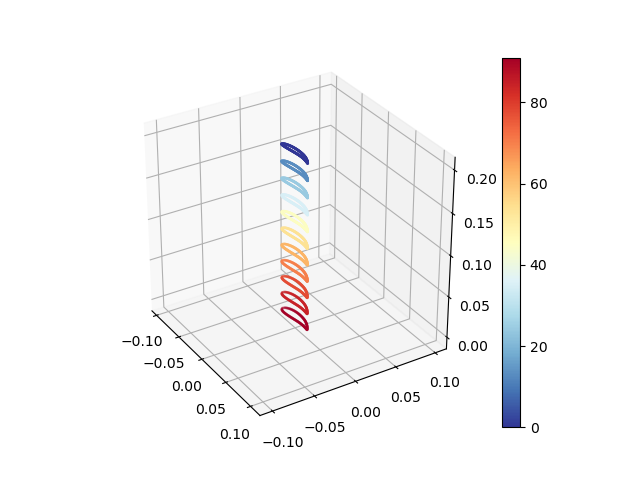

In [35]:
_, ax = plt.subplots(subplot_kw={"projection": "3d"})
cm = plt.cm.get_cmap("RdYlBu").reversed()

sm = ax.scatter3D(
    x_stacked,
    y_stacked,
    z_stacked,
    c=stress,
    cmap=cm,
    s=1
)
plt.colorbar(sm, ax=ax)

ax.set_box_aspect([1.0, 1.0, 1.0])
set_axes_equal(ax)

In [37]:
from ipywidgets import interact, IntSlider, FloatSlider


def plot_blade_stress(blade_length: int, m: int, p: int, t: int):
    
    x_stacked, y_stacked, z_stacked, (z_values, areas) = build_3d_scatters(blade_length, m, p, t)
    f_area = np.poly1d(np.polyfit(z_values, areas, 3))

    stress = np.array([
            blade_tension_stress(
            z=_z,
            density=density,
            blade_area=f_area,
            blade_length=blade_length,
            rotation_speed=n,
            root_radius=(avg_d - blade_length) / 2,
        ) / 1e6 
            for _z in z_values 
    ])

    stress = np.ones_like(x_stacked) * stress
    plt.close()
    _, ax = plt.subplots(subplot_kw={"projection": "3d"})
    cm = plt.cm.get_cmap("RdYlBu").reversed()

    sm = ax.scatter3D(
        x_stacked,
        y_stacked,
        z_stacked,
        c=stress,
        cmap=cm,
    )
    plt.colorbar(sm, ax=ax)

    ax.set_box_aspect([1.0, 1.0, 1.0])
    set_axes_equal(ax)

interact(
    plot_blade_stress,
    blade_length=FloatSlider(min=0.03, max=0.5, value=l, step=0.01),
    m=IntSlider(min=1, max=9, step=1, value=2),
    p=IntSlider(min=1, max=9, step=1, value=4),
    t=IntSlider(min=30, max=99, step=1, value=30),
);

interactive(children=(FloatSlider(value=0.2, description='blade_length', max=0.5, min=0.03, step=0.01), IntSli…

In [38]:
%matplotlib inline

# Расчет напряжений в дисках

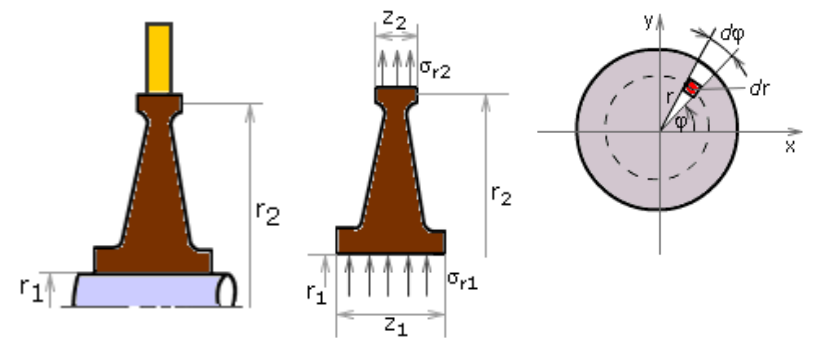

Формулы для определения радиальных и тангенсальных напряжений в диске постоянной толщины с отверстием имеют следующий вид:


$$
\sigma_{r}(r) = \frac{r_2^2}{r_2^2 - r_1^2}(1 - \frac{r_1^2}{r^2})\sigma_{r2}
-\frac{r_2^2 - r^2}{r_2^2 - r_1^2}\frac{r_1^2}{r^2}\sigma_{r1}
+\frac{3 + \nu}{8}(r_2^2 + r_1^2 - \frac{r_1^2 r_2^2}{r^2} - r^2)\rho\omega^2
$$


$$
\sigma_{\theta}(r) = \frac{r_2^2}{r_2^2 - r_1^2}(1 + \frac{r_1^2}{r^2})\sigma_{r2}
-\frac{r_2^2 + r^2}{r_2^2 - r_1^2}\frac{r_1^2}{r^2}\sigma_{r1}
+\frac{3 + \nu}{8}(r_2^2 + r_1^2 + \frac{r_1^2 r_2^2}{r^2} - \frac{1 + 3 \nu}{3 + \nu}r^2)\rho\omega^2
$$


Где $\sigma_{r2}$ - напряжения на переферии диска. Например от лопаток. $\sigma_{r1}$ - напряжения на расточке диска, например от посадки

В диске с отверстием радиальные напряжения имеют максимум между радиусами $r_1$ и $r_2$. Тангенциальные напряжения максимальны на поверхности отверстия и всюду растягивающие. В диске, посаженном на вал с натягом, на расточке имеют место сжимающие радиальные напряжения. 

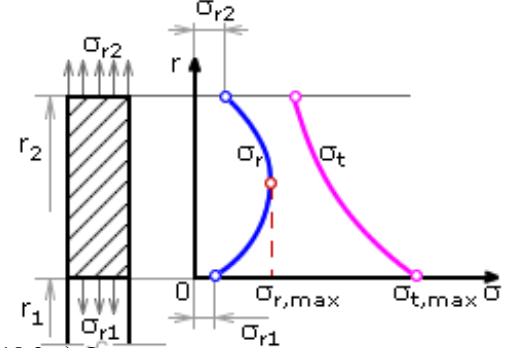

Для диска без отверстия

$$
\sigma_{r}(r) =\frac{3 + \nu}{8}\rho\omega^2(r_2^2 - r^2) + \sigma_{r2}
$$

$$
\sigma_{\theta}(r) =\frac{3 + \nu}{8}\rho\omega^2(r_2^2 - \frac{1 + 3 \nu}{3 + \nu}r^2) + \sigma_{r2}
$$

Где $\nu$ – коэффициент Пуассона (отношение относительной поперечной деформации к относительной продольной).

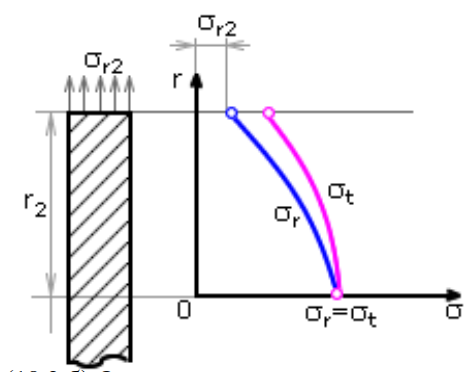

Для дисков переменной толщины применяются иные методы. Например методом трех расчетов

### Задача 2

Определить максимальные напряжения и запас прочности для дисков постоянной толщины, выполненных с отверстием и без него. Известно напряжение от лопаточной нагрузки 100 МПа. Напряжения от посадки 40 МПа. Соответствующие радиусы дисков: внешний 0.55 м, внутренний 0.22 м. Диски выполнены из стали 34ХМА для которой предел длительной прочности 510 МПа, плотность 7800 кг/м3

In [52]:
nu = 0.3
r1 = 0.22
r2 = 0.55
sigma_1 = -40 * MPa
sigma_2 = 100 * MPa
density = 7800
n = 50

angular_speed = 2 * np.pi * n

max_stress = 510 * MPa

Для диска с отверстием

In [53]:
def sigma_r(r, r1, r2, sigma_1, sigma_2):
    first = (r2 ** 2 / (r2**2 - r1**2)) * (1 - (r1**2)/(r**2)) * sigma_2
    second = ((r2**2 - r**2) * r1**2) * sigma_1 / ((r2**2 - r1**2)*(r**2))
    brackets = r2**2 + r1**2 - (r1**2 * r2**2) / r**2 - r**2
    third = (3 + nu) * brackets * density * angular_speed ** 2
    return first - second + third


def sigma_theta(r, r1, r2, sigma_1, sigma_2):
    first = (r2 ** 2 / (r2**2 - r1**2)) * (1 + (r1**2)/(r**2)) * sigma_2
    second = ((r2**2 + r**2) * r1**2) * sigma_1 / ((r2**2 - r1**2)*(r**2))
    innet_brackets = (1 + 3 * nu) * (r**2) / (3 + nu)
    brackets = r2**2 + r1**2 + ((r1**2) * ((r2**2)) / (r**2)) - innet_brackets
    third = ((3 + nu) / 8) * brackets * density * angular_speed ** 2
    return first - second + third

In [54]:
print(
    sigma_r(r1, r1=r1, r2=r2, sigma_1=sigma_1, sigma_2=sigma_2) / MPa, 
    sigma_r(r2, r1=r1, r2=r2, sigma_1=sigma_1, sigma_2=sigma_2) / MPa
)

40.0 100.0


In [55]:
print(
    sigma_theta(r1, r1=r1, r2=r2, sigma_1=sigma_1, sigma_2=sigma_2) / MPa,
    sigma_theta(r2, r1=r1, r2=r2, sigma_1=sigma_1, sigma_2=sigma_2) / MPa
)

491.9742717480123 224.8254412973503


In [56]:
print(
    "Коэффициент запаса прочности: ",
    max_stress/sigma_theta(r1, r1=r1, r2=r2, sigma_1=sigma_1, sigma_2=sigma_2)
)

Коэффициент запаса прочности:  1.036639575049202


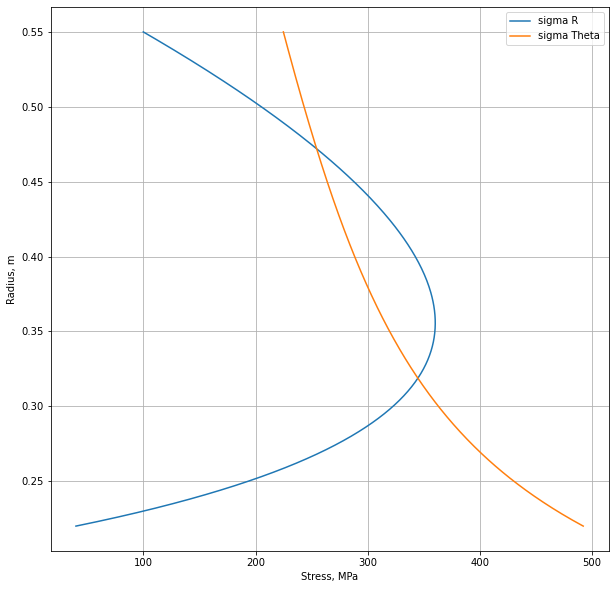

In [57]:
r = np.arange(r1, r2, 0.001)

fig, ax = plt.subplots(1,1,figsize=(10, 10))

ax.plot(sigma_r(r, r1=r1, r2=r2, sigma_1=sigma_1, sigma_2=sigma_2) / MPa, r, label='sigma R')
ax.plot(sigma_theta(r, r1=r1, r2=r2, sigma_1=sigma_1, sigma_2=sigma_2) / MPa,  r, label='sigma Theta')
ax.legend()
ax.set_xlabel("Stress, MPa")
ax.set_ylabel("Radius, m")
ax.grid();

Для диска без отверстия

In [58]:
def sigma_r(r, r2, sigma_2):
    a = (3 + nu) / 8
    return a * density * (angular_speed ** 2) * (r2**2 - r**2) + sigma_2

def sigma_theta(r, r2, sigma_2):
    a = (3 + nu) / 8
    b = (1 + 3 * nu) / (3 + nu)
    return a * density * (angular_speed ** 2) * (r2**2 - b * r**2) + sigma_2

In [59]:
print(
    sigma_r(0, r2=r2, sigma_2=sigma_2) / MPa,
    sigma_r(r2, r2=r2, sigma_2=sigma_2) / MPa
)

196.06024278552772 100.0


In [60]:
print(
    sigma_theta(0, r2=r2, sigma_2=sigma_2) / MPa,
    sigma_theta(r2, r2=r2, sigma_2=sigma_2) / MPa
)

196.06024278552772 140.75283027264808


In [61]:
print(
    "Коэффициент запаса прочности: ",
    max_stress/sigma_theta(0, r2=r2, sigma_2=sigma_2)
)

Коэффициент запаса прочности:  2.6012412958087285


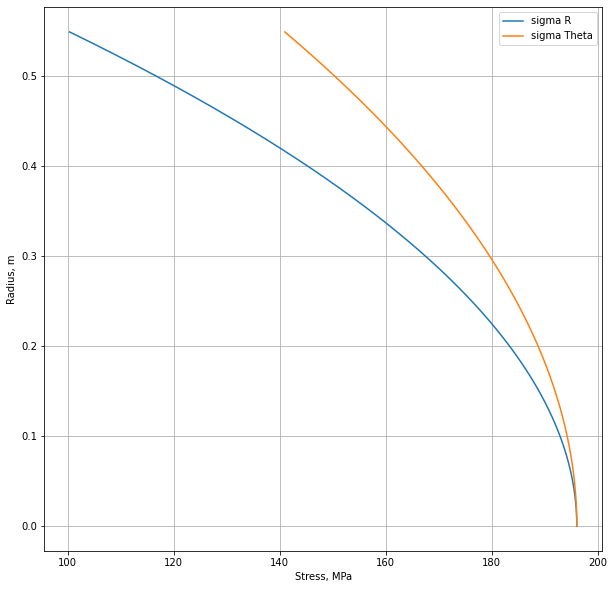

In [62]:
r = np.arange(0, r2, 0.001)

fig, ax = plt.subplots(1,1,figsize=(10, 10))

ax.plot(sigma_r(r, r2=r2, sigma_2=sigma_2) / MPa, r, label='sigma R')
ax.plot(sigma_theta(r, r2=r2, sigma_2=sigma_2) / MPa,  r, label='sigma Theta')
ax.legend()
ax.set_xlabel("Stress, MPa")
ax.set_ylabel("Radius, m")
ax.grid();

Запас прочности при таком значении напряжения может оказаться не достаточным. Одним из способов повышения запаса прочности является исполнение диска со ступицей, позволяющей сократить уровень напряжений на расточке.

# Оценка надежности ротора паровой турбины

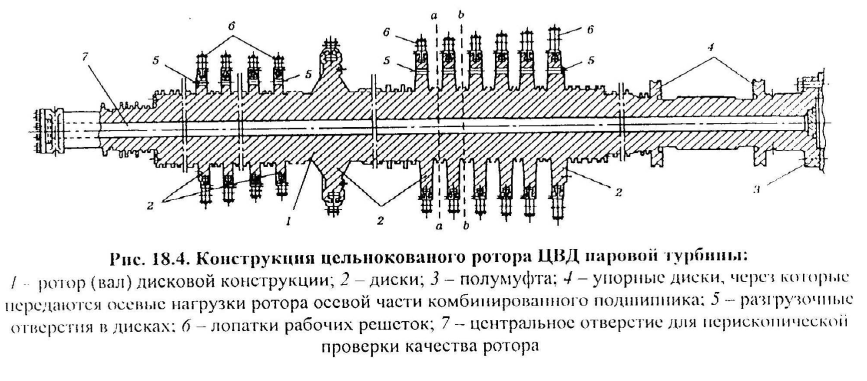

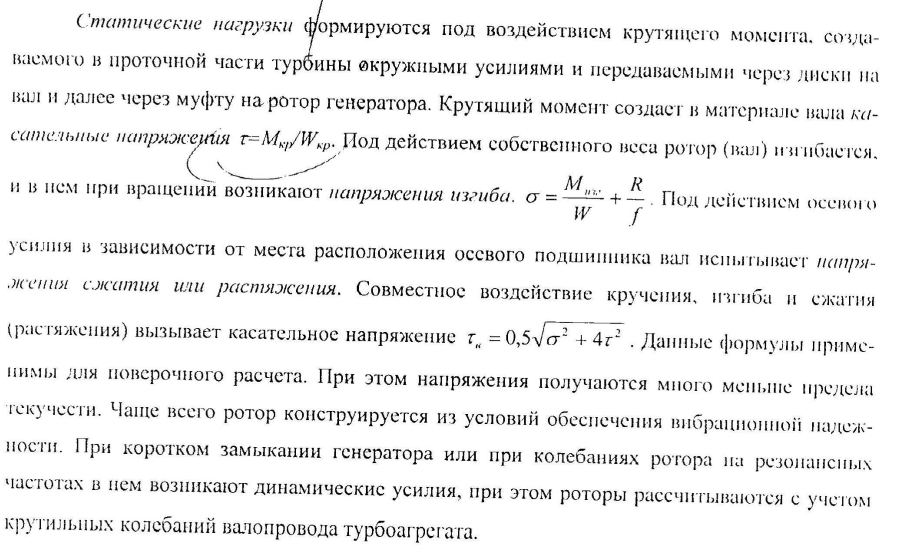

### Задача 3

Определить запас прочности по касательным напряжениям в шейке ротора диаметром 0.325 м, находящейся в обоасти осерадиального подшипника ЦВД турбины. Эффективная мощность 115 МВт. Допустимые касательные напряжения металла 331 МПа

In [40]:
N = 115 * MW
d = 0.325
n = 50
max_tan_stress = 331 * MPa

Крутящий момент исходя из мощности

In [41]:
moment = N / (2 * np.pi * n)
moment

366056.3691113593

Момент сопротивления посчитанный для окружности

In [42]:
W = np.pi * d ** 3 / 16
W

0.006740311581969508

Касательные напряжения

In [43]:
tau = moment / W
tau / MPa

54.308523376065985

In [44]:
print("Коэффициент запаса прочности: ", max_tan_stress / tau)

Коэффициент запаса прочности:  6.094807581269522


Следует помнить, что в условиях короткого замыкания электрогенератора в роторе возникают динамические составляющие сложного напряженного состояния. Поэтому обычно принимают условие о том, что коэффициент запаса прочности должен быть 4-6

# Расчет критических частот вращения ротора

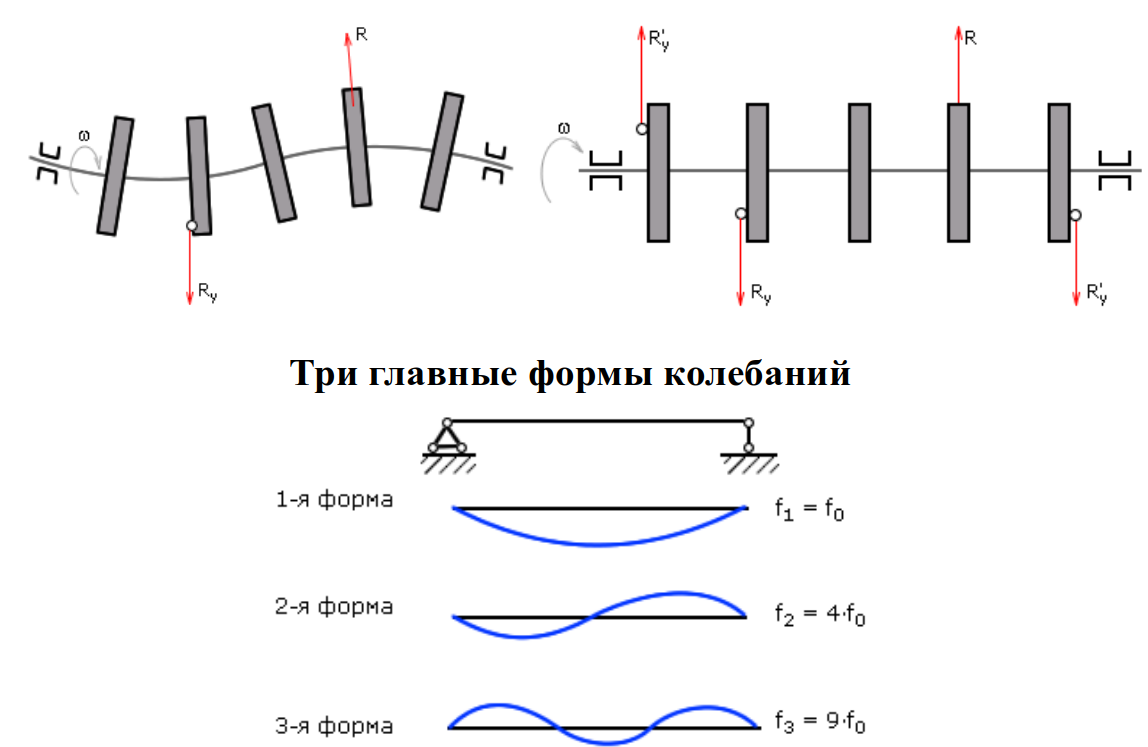

Вращающийся ротор является источником колебшиий и одиовременно злементом, который подвержен колебаниям. Возможны изгибные (поперечиые) и крутильные колебания, причинами которых являются:
неуравновешенность ротора, неточность сборки и соединений, неравножесткость сечений вала, овальность шеек ротора, действие неконсервативных сил, возбуждающих автоколебания ротора

В общем случае вибрацию турбоагрегата оценивают по её спектральным характеристикам, получаемым в процессе изменения одного из параметров вибрации на крышках подшипников валопровода. Если в спектре вибрации преобладает синусоида обратной частоты, то такую вибрацию называют вибрацией обратной частоты. Если преобладает синусоида с частотой равной примерно половине частоты вращения ротора, то вибрацию называют низкочастотной. Когда в спектре вибрации решаюзую роль играет синусоида с двойной частотой вращения, вибрацию называют высокочастотной.

Важнейшим для ротора являются его критические частоты вращения, которые обнаруживаются при снятии  амплитудио-частотной характеристики. При этом рассматривают обычно три главные формы колебаний ротора. Рабочая частота вращения ротора турбоагрегата должна отличаться от критический с достаточным запасом. При совпадении частоты вращения с критическими частотами возникает явление резонанса, сопровождающееся повышенной вибрацией ротора. Приближенная оценка первой и второй критических частот может быть осуществлена с помощью аналога формулы **Донкерли** справедливой для собственных частот колебаний ротора на упругих опорах


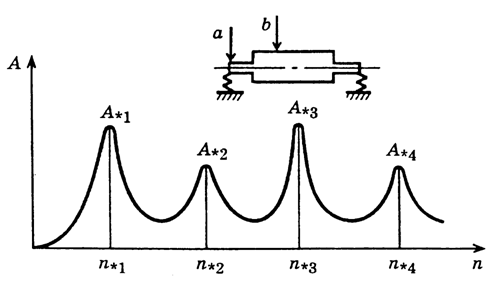

Аналог формулы **Донкерли** справедливой для собственных частот колебаний ротора на упругих опорах


$$P_j = \frac{1}{\sqrt{\frac{1}{P_{1j}^2} + \frac{1}{P_2j^2}}}$$

Где $P_{1j}$ - рад/с - j-я частота ротора на абсолютно жестких опорах, которая находится по формуле:

$$P_{1j} = \frac{(j\pi)^2}{L^2}\sqrt{\frac{EI}{M/L_{ротора}}}$$

Где 
* L - расстояние между осями подшипников ротора
* $L_{ротора}$ - длинна ротора
* М - масса ротора
* EI - средняя изгибная жесткость ротора

Эту жесткость можно оценить по эквивалентному диаметру $D_э$ ротора (Во многих случаях допускается D принять по диаметру диафрагменного уплотнения без учета ужесточения ротора дисками), диаметру центрального отверстия $D_0$ и модулю упругости при средней температуре ротора $E_{tср}$

$$EI=E_{tср}\frac{\pi}{64}(D_э^4 - D_0^4)$$

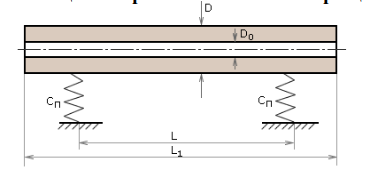

Собственные частоты ротора $Р_{2j}$ как жесткого целого, опирающегося на упругие опоры с податливостью $\delta_n$ определяются следующим образом:

$$(P_2)_1 = \sqrt{\frac{2}{M\delta_n}}$$ 
$$(P_2)_2 = \sqrt{3}\frac{L}{L_{ротора}}\sqrt{\frac{2}{M\delta_n}}$$

Податливость опор $\delta_n$ складывается из податливости масляной плёнки во вкладыше подшипника и податливости его корпусных элементов, включая фундаментные опорные элементы: $\delta_n=\delta_{мп}+\delta_{оп}$. Податливость масляной плёнки $\delta_{мп} = 1/С_{мп}$ оценивается по её жесткости в горизонтальной ($С_г = (0,1÷0,5)*10^9$ Н/м) и вертикальной ($С_в = (0,6÷1,2)*10^9$ Н/м) плоскостях. Податливость статорных частей может быть принята в диапазоне $\delta_{оп} = (0,2÷5)*10^{-9}$ м/Н.

Приближенная оценка первого критического числа оборотов ротора осуществляется по формуле **В.В. Звягинцева**:
$$n_{кр} = 7.5 \frac{(D_э / L)^2}{\sqrt{M / L}}$$

Где
* D, мм - максимальный диаметр вала
* L, м - пролет между осями подшипников
* M, кг - Вес ротора 

Eсли критическая частота вращения ротора превышает рабочую частоту (nкр>nраб) то ротор (вал) называют жестким, и наоборот, если nкр<nраб, то - гибким. 

### Задача 4

Оценить критическое число оборотов ротора весом 9936 кг при эквивалентном диаметре $D_э$=0.47м и пролете между осями подшипников L = 4.945 м. Рабочая частота вращения ротора 50 Гц.

In [45]:
n = 50
diameter = 470  # in mm
L = 4.945  # in m
mass = 9936  # in kg

In [46]:
def critical_speed(mass, n, d, l):
    numenator = (d / l) ** 2
    denumenator = (mass / l) ** 0.5
    return 7.5 * numenator / denumenator

In [47]:
n_critical = critical_speed(mass=mass, n=n, d=diameter, l=L)  # in rpm
n_critical

1511.477699542358

In [48]:
rps = n_critical / 60  # in rps
rps

25.191294992372637

In [49]:
rps < n

True

Полученный результат $n_{крит} < n$ говорит о том, что ротор относится к гибкому типу

### Задача 5

Определить критические частоты вращения цельнокованного ротора выполненого из стали 20Х1М1 плотностью 7800 кг/м3, модуль упругости $E = 1.8 \cdot 10^5$ МПа, предел текучести $\sigma_{0.2} = 570$МПа

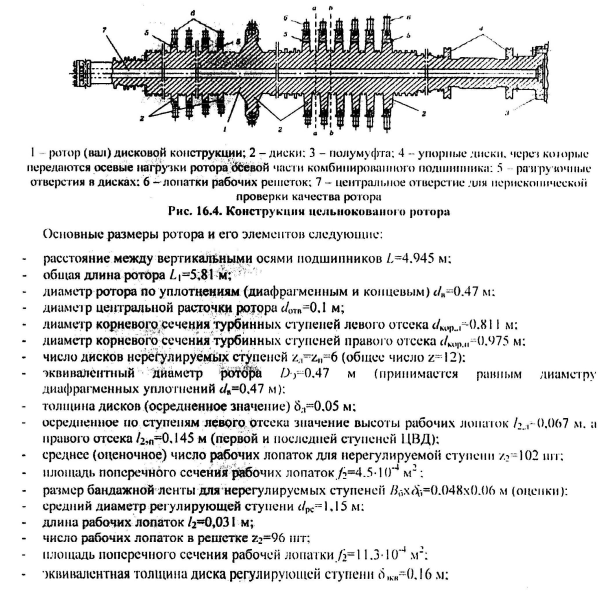

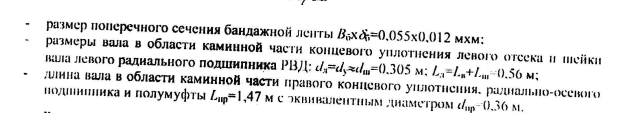

In [50]:
E = 1.8 * 10**11
density = 7800


L = 4.945
L_rotor = 5.81
d = 0.47
d_0 = 0.1
d_root_l = 0.811
d_root_r = 0.975
z_disk = 6
disk_thickness = 0.05
l_l = 0.067
l_r = 0.145
z = 102
f = 4.5 * 10**-4
B_bandage = 0.048
delta_bandage = 0.06
d_reg = 1.15
l2 = 0.031
z2 = 96
f2 = 11.3 * 10**-4
reg_disk_thickness = 0.16
B_reg_bandage = 0.055
delta_reg_bandage = 0.012
d_l = 0.305
L_l = 0.56
L_r = 1.47
d_r = 0.36

L_center = L_rotor - L_r - L_l

##### Рассчет массы ротора

Масса вала без учета массы дисков вычисляется:
$$m_в = 0.25\pi \rho L \cdot(d^2 - d_{отв}^2)$$
Для приведенной констурции ротора
$$m_в = 0.25\pi \rho \cdot[L_l(d_l^2 - d_{отв}^2) + L_{ц}(d_ц^2 - d_{отв}^2) + L_{п}(d_п^2 - d_{отв}^2)]$$

In [51]:
mass_1 = 0.25 * density * np.pi * (
    (L_l * (d_l ** 2 - d_0 ** 2)) +
    (L_center * (d ** 2 - d_0 ** 2)) + 
    (L_r * (d_r ** 2 - d_0 ** 2))
)
mass_1

6245.613743998244

Масса дисков нерегулируемых ступенй вычисляется по формуле:
$$m_{днр}=0.25 \pi \rho z \delta (d_{кор}^2 - d_{ц}^2)$$

In [52]:
mass_2 = 0.25 * density * np.pi * z_disk * disk_thickness * (
    (d_root_l ** 2 - d ** 2) + 
    (d_root_r ** 2 - d ** 2)
)

mass_2

2143.9152210496172

Масса рабочих лопаток и бандажных лент нерегулируемых ступеней

In [53]:
mass_3 = density * (
    (z_disk * z * f * l_l) + 
    (z_disk * z * f * l_r) + 
    0.25 * np.pi * B_bandage * (
        ((d_root_l + l_l + delta_bandage) ** 2 - (d_root_l + l_l) ** 2) * z_disk +
        ((d_root_r + l_r + delta_bandage) ** 2 - (d_root_r + l_r) ** 2) * z_disk
    )
)

mass_3

891.117520523869

Масса регулирующей ступени состоит из массы диска, рабочих лопаток и бандажной ленты

In [54]:
mass_4 = (
    0.25 * density * np.pi * ((d_reg - l2) ** 2 - d ** 2) * reg_disk_thickness +
    l2 * f2 * density * z2 +
    0.25 * np.pi * density * ((d_reg + l2 + delta_reg_bandage) ** 2 - (d_reg + l2) ** 2) * B_reg_bandage
)

mass_4

1046.6473096535371

Масса ротора

In [55]:
rotor_mass = mass_1 + mass_2 + mass_3 + mass_4
rotor_mass

10327.293795225267

Средняя изгибная жесткость ротора

In [56]:
EI = E * np.pi * (d ** 4 - d_0 ** 4) / 64
EI

430271832.7947879

Тогда первая собственная частота вращения ротора по первому тону колебаний на абсолютно жестких опорах

In [57]:
P_11 = (np.pi ** 2 / L ** 2) * (EI / (rotor_mass / L_rotor)) ** 0.5

P_11  # rad / s 

198.57904229661537

В свою очередь, частота по второму тону колебаний

In [58]:
P_12 = 4 * P_11

P_12  # rad / s 

794.3161691864615

Для расчета податливости опор ротора зададимся $C_г = 0.5 \cdot 10^9 $ Н/м и $\delta_{оп} = 0.5 \cdot 10^{-9}$ м/Н

In [59]:
delta_op = 0.5 * 10 ** -9
C_horizontal = 0.5 * 10 ** 9
delta_opor = delta_op + 1 / C_horizontal
delta_opor

2.5e-09

2-e собственные частоты вращения ротора на упругих опорах оцениваются по формулам

In [60]:
P_21 = (2 / (rotor_mass * delta_opor)) ** 0.5
P_21  # rad / s

278.3246857577964

In [61]:
P_22 = (L / L_rotor) * 3 ** 0.5 * P_21

P_22  # rad / s

410.3009460146994

В итоге первая критическая частота вращения ротора

In [62]:
P_1 = 1 / (
    (1 / P_11 ** 2) + (1 / P_21 ** 2) 
) ** 0.5

P_1  # rad / s

161.65200786365043

In [63]:
P_1 / (2 * np.pi)  # Hz

25.727716112229903

И вторая

In [64]:
P_2 = 1 / (
    (1 / P_12 ** 2) + (1 / P_22 ** 2) 
) ** 0.5

P_2  # rad / s

364.5399070076032

In [65]:
P_2 / (2 * np.pi)  # Hz

58.01832815451991

# Оценки вибрационной надежности пакета рабочих лопаток

Основными источниками возбуждения переменных во времени нагрузок в рабочих лопатках являются

* кромочные следы за сопловой решеткой ступени
* нестационарные волновые явления в виде скачков уплотнения
* технологические отклонения при изготовлении диафрагм
* неравномерность поля скоростей из-за наличия патрубков отбора пара
* парциальный подвод водяного пара
* вибрация ротора
* задевания в различного рода уплотнений
* формирование отрывных зон в проточной 
* части турбины

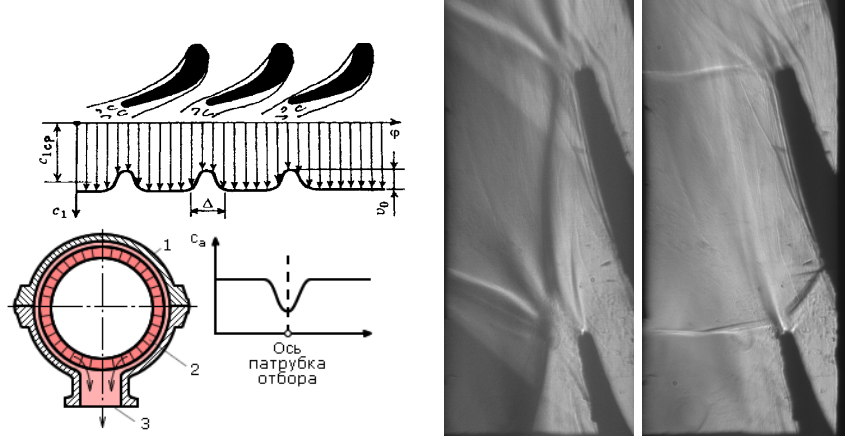

Действительные частоты колебаний рабочей лопатки постоянного по её высоте профиля определяются по формуле

$$f_i = \psi \frac{m_i}{l^2}\sqrt{\frac{EJ}{\rho F}}$$

$m_1 = 0.56$, $m_2 = 3.51$, $m_3 = 9.82$ - Величины для первых трех тонов колебаний

Получаемые при этом значения частот колебаний единичнной лопатки определяются при неподвижном роторе турбины. Из-за упругости заделки хвостовика лопатки в расчетах используют поправочный коэффицент $\psi$, значения которого для первого тона колебаний в зависимости от гибкости лопатки $\lambda = l / i$, $i = (J_x / F_x) ^ {0.5}$

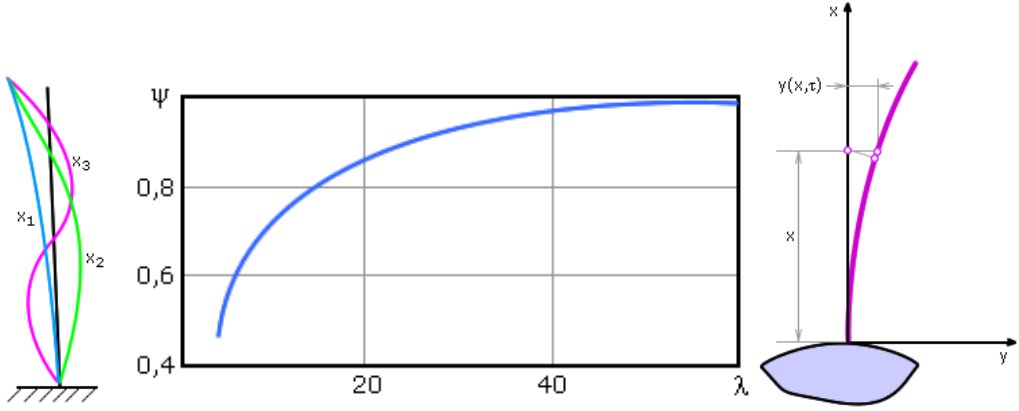

Для уменьшения динамических усилий лопатки связывают бандажной лентой в пакеты. Ве формы колебаний лопаток, соединенных бандажом, разделяются на два типа. Тип А - когда все лопатки колеблются в одной фазе. Тип В - когда не все лопатки колеблются в одной фазе. Тон колебаний обозначается с индексом, равным числу узлов на упругой линии лопаток.

Тип А:

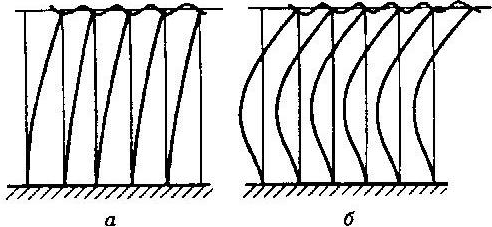

Тип В:

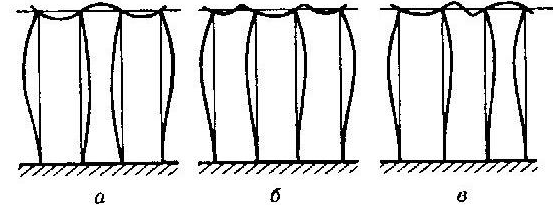

Для определения частот колебаний пакета лопаток в формулу вводится множитель $\phi$, учитывающий влияние жесткости и массы надбандажной ленты. Его значение находится по зависимости представленой на графике, где по оси Х располагается коэффицент жесткости бандажа $k_б$

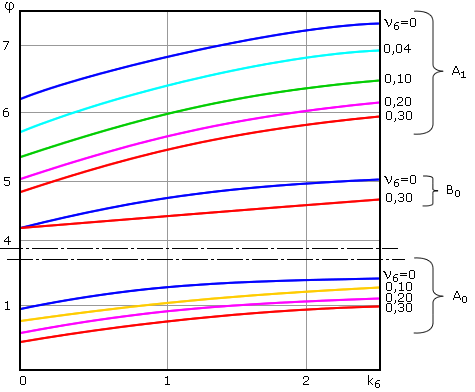

$$k_б = \frac{12(m-1)H_бЕ_бJ_бl\cdot cos^2(\beta_у)}{mt_бEJ}$$

В формуле:
* $H_б$ = 0.1 - 0.3 если бандаж **приклепан** к перу лопаток
* $H_б$ = 0.6 - 1.0 если бандаж **припаян** к перу лопаток
* $E_б$ - модуль упругости банадажа
* $J_б$ - момент инерции банадажа
* $t_б$ - шаг банадажа (длинна приходящаяся на одну лопатку)
* $\beta_у$ - угол между направлением вращения диска и нормалью к плоскости минимальной жесткости
* $\nu_б = m_б / m_л$ - отношение массы бандажа, приходящей на одну лопатку, к массе лопатки

Частоту собственных колебаний рабочих лопаток при вращении диска называют динамической. Её связь со статической частотой для случая неподвижного диска определяется выражением:
$$f_{дин} = \sqrt{f_{ст}^2 + B n ^2}$$

Значение коэффициента В для отдельных лопаток вычисляется по выражению
$$B = 0.786 d_{ср} / l + 0.407 - cos^2(\beta_у)$$
Для пакета лопаток
$$B = 0.5 (\frac{d_{ср}}{l} -1) \frac{1/2 + \nu_б}{1/3 + \nu_б} + sin^2(beta_y)$$

В работающей турбинной ступени всегда существуют возмущающие силы, которые кратны частоте вращения ротора. Их называют **возмущающими силами первого порядка**, если коэффициент кратности k=1,2..$\inf$ не совпадает с числом лопаток сопловой решетки. И **возмущающими силами второго рода**, если коэффициент кратности равен числу лопаток сопловой решетки. Частота возмущающих сил первого рода f=kn, а второго рода f=zn, 2zn ...

Частота вращения при которой лопатка попадет в резонанс определяется формулой.

$$n_{р} = \frac{f}{\sqrt{k^2 - B}}$$

Опасные зоны работы лопаточного аппарата определяются с помощью вибрационной диаграммы

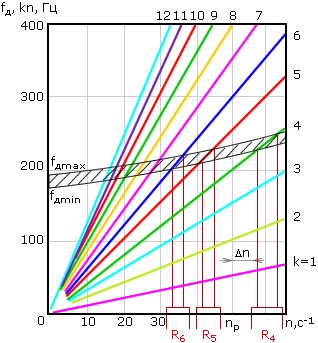

### Задача 6

Определить собственные частоты колебаний пакета лопаток в статических условиях и динамических условиях. Средний диаметр ступени 1.053 м. Длинна рабочей лопатки 0.211 м. Площадь сечения лопатки 2.44 * 10е-4 м2. Момент инерции 0.43 * 10e-8 м4. $\beta_у$ = 85. Плотность стали 12Х13 8000 кг/м3. Модуль упругости Е=2 * 10е11 Па. Число рабочих лопаток z=84. Размер бандажной ленты $B_б x \delta$ = 40 х 5 мм. Число лопаток в пакете m = 12. $t_б$ = 25 мм

In [66]:
m = 12
t = 25 * mm
beta = 85
density = 8000
E = 2 * (10**11)
z = 84
d = 1.053
l = 0.211
f = 2.44 * (10 ** (-4))
J = 0.43 * (10 ** (-8))

delta = 5 * mm
B = 40 * mm

In [67]:
i = (J / f) ** 0.5

_lambda = l / i
_lambda

50.262390581594346

По графику примем $\psi$ = 0.98

In [68]:
psi = 0.98

In [69]:
def static_frequency(i):
    _m = {
        1: 0.56,
        2: 3.51,
        3: 9.82
 
    }
    first = psi * _m[i] / (l ** 2)
    second = ((E * J) / (density * f)) ** 0.5
    return first * second

In [70]:
static_frequency(1), static_frequency(2), static_frequency(3)

(258.73698377679466, 1621.7264518866946, 4537.137822657362)

Коэффициент жесткости бандажа

In [71]:
H = 0.12
J_b = B * (delta ** 3) / 12

k = (12 * (m - 1) * H * E * J_b * l * np.sin(np.deg2rad(beta)) ** 2) / (m * t * J * E)
k

1.0713346034282176

In [72]:
nu = B * delta * t / (f * l)
nu

0.09711755108383188

In [73]:
f_a0 = static_frequency(1) * 0.8
f_a1 = static_frequency(1) * 6
f_b0 = static_frequency(1) * 4.2

f_a0, f_a1, f_b0  # Hz

(206.98958702143574, 1552.421902660768, 1086.6953318625376)

Влияение вращения на собственные частоты колебаний пакета лопаток

In [74]:
B_bandage = 0.5 * ((d/l) - 1) * ((nu+1/2)/(nu+1/3)) + np.sin(np.deg2rad(beta)) ** 2
B_bandage

3.760211318185405

In [75]:
def to_dynamic_frequency(f, n=50):
    root = (1 + B_bandage * (n / f) ** 2) ** 0.5
    return f * root

In [76]:
to_dynamic_frequency(f_a0), to_dynamic_frequency(f_a1), to_dynamic_frequency(f_b0)

(228.57212741445102, 1555.4466535874326, 1091.0120405326857)

In [77]:
def min_max(f, delta=0.05):
    return f * (1-delta) , f * (1 + delta)

In [78]:
n_line = np.linspace(0, 60)
min_line, max_line = min_max(to_dynamic_frequency(f_a0, n=n_line))

In [79]:
def k_line(k, n=n_line):
    return k * n_line

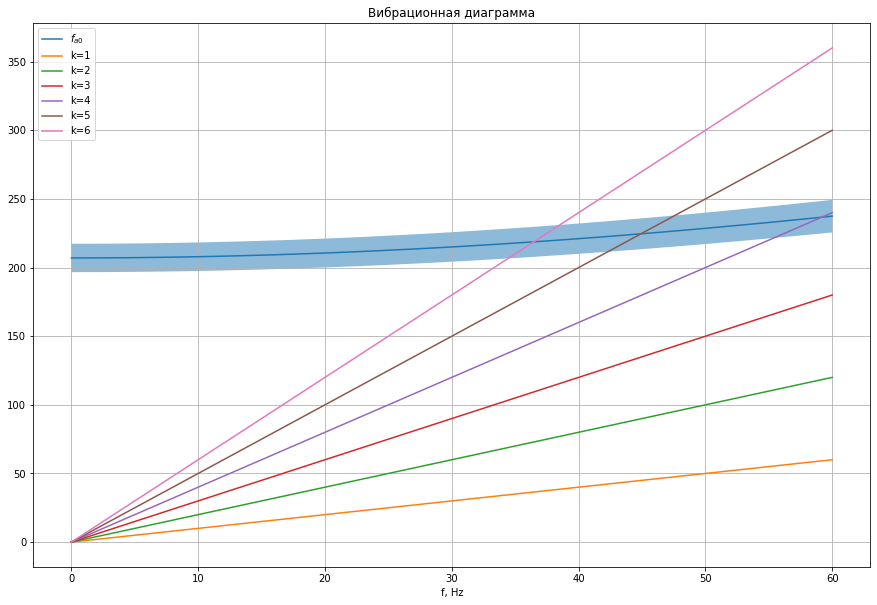

In [80]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
ax.plot(n_line, to_dynamic_frequency(f_a0, n=n_line), label='$f_{a0}$')
ax.fill_between(n_line, y1=min_line, y2=max_line, alpha=0.5)

ax.plot(n_line, k_line(1), label=f'k={1}')
ax.plot(n_line, k_line(2), label=f'k={2}')
ax.plot(n_line, k_line(3), label=f'k={3}')
ax.plot(n_line, k_line(4), label=f'k={4}')
ax.plot(n_line, k_line(5), label=f'k={5}')
ax.plot(n_line, k_line(6), label=f'k={6}')
ax.set_xlabel("n, rps")
ax.set_xlabel("f, Hz")
ax.grid()
ax.legend()
ax.set_title("Вибрационная диаграмма");